In [37]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from cmdstanpy import CmdStanModel
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

dp_mix_stan = """
data
{
    int<lower=1> I; // number of areal locations
    int<lower=1> T; // number of time steps
    int<lower=1> P; // number of covariates
    int<lower=1> H; // truncation of stick breaking construction dp
    
    vector[I*T]     y; // output values
    matrix[I*T,P+1] X; // covariate matrix
    // syntax: y(i,t) = y[T*(i-1) + t]
    
    matrix[I,I] W_raw; // proximity matrix
      
    // hyperpar vector of regressors
    vector[P+1]     mu_0; 
    matrix[P+1,P+1] Sigma_0;
    
    // w_1
    vector[I] mu_w_1;
    
    // alpha
    real<lower=0> a_alpha;
    real<lower=0> b_alpha;
    
    // tau^2
    real<lower=0> a_tau2;
    real<lower=0> b_tau2;
    
    // sigma^2
    real<lower=0> a_sigma2;
    real<lower=0> b_sigma2;
    
    // rho
    real<lower=0> alpha_rho;
    real<lower=0> beta_rho;
    
    //xis
    real<lower=0> a_xi;
    real<lower=0> b_xi;
}

transformed data
{
    vector[T] ones_T;
    for (t in 1:T)
        ones_T[t] = 1;
    
    matrix[T,T] eye_T;
    eye_T = diag_matrix(ones_T);
 
    vector[I] ones_I;
    for (i in 1:I)
        ones_I[i] = 1;
    
    matrix[I,I] eye_I;
    eye_I = diag_matrix(ones_I);
        
    matrix[I,I] W;
    W = diag_matrix(W_raw*ones_I) - W_raw;
}

parameters
{
    real<lower=1e-8> alpha;
    real<lower=0> sigma2;
    real<lower=0> tau2;
    real<lower=0,upper=1> rho;
    
    
    // autoregressive coefficients still to reparametrize
    vector<lower=0,upper=1>[I]    xis_constructors;
    
    // random effects
    matrix[T,I]                ws;
    
    // betas for the mixture of the dirichlet process
    matrix[P+1,H]              betas; 
    
    // for the construction of the dirichlet process
    vector<lower=0,upper=1>[H-1] vs;
}

transformed parameters
{   // weights stick breaking construction
    simplex[H] omegas; 
    
    // sbc stuff
    vector<lower=0, upper=1>[H-1] cumprod_one_mv;    
    cumprod_one_mv = exp(cumulative_sum(log1m(vs)));
    
    omegas[1] = vs[1];
    omegas[2:(H-1)] = vs[2:(H-1)] .* cumprod_one_mv[1:(H-2)];
    omegas[H] = cumprod_one_mv[H-1];

}

model
{
    alpha  ~ gamma(a_alpha,b_alpha);
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    tau2   ~ inv_gamma(a_tau2,b_tau2);
    rho    ~ beta(alpha_rho,beta_rho);
    vs     ~ beta(1,alpha);
    vector[I] xis;
    for (i in 1:I){
        xis_constructors[i] ~ beta(a_xi,b_xi);
        xis[i]=2*xis_constructors[i]-1;
     }   
     
    matrix[I,I] inv_Q;
    inv_Q = inverse_spd(rho*W + (1-rho)*eye_I);
    
    ws[1,1:I] ~ multi_normal(mu_w_1, tau2*inv_Q);
    
    for (t in 2:T)
        ws[t,1:I] ~ multi_normal(ws[t-1,1:I]*diag_matrix(xis), tau2*inv_Q);
    
    for (h in 1:H)
        betas[1:P+1,h] ~ multi_normal(mu_0, Sigma_0);
        
    for (i in 1:I) {
        vector[H] log_probs;
        
        for (h in 1:H) 
            log_probs[h] = log(omegas[h]) + multi_normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h] + ws[1:T,i], sigma2*eye_T);
        
        target += log_sum_exp(log_probs);
    }
    matrix[I,H] log_probs;
    for (i in 1:I) 
    {
        for (h in 1:H) 
            log_probs[i,h] = log(omegas[h]) + multi_normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h]  + ws[1:T,i]  , sigma2*eye_T);
    
    }
}

generated quantities 
{   
    // vector of cluster allocations
    vector[I] s;
    
    matrix[I,H] log_probs;
    for (i in 1:I) 
    {
        for (h in 1:H) 
            log_probs[i,h] = log(omegas[h]) + multi_normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h]  + ws[1:T,i]  , sigma2*eye_T);
    
    }
    for (i in 1:I)
        s[i] = categorical_rng(softmax(log_probs[i,1:H]'));

    
}
"""

stan_file = "bayesian.stan"

with open(stan_file, "w") as fp:
    fp.write(dp_mix_stan)
    
dp_mix = CmdStanModel(stan_file=stan_file)

17:22:44 - cmdstanpy - INFO - compiling stan file /home/anna-ubuntu/bayesian-project/bayesian.stan to exe file /home/anna-ubuntu/bayesian-project/bayesian
17:24:48 - cmdstanpy - INFO - compiled model executable: /home/anna-ubuntu/bayesian-project/bayesian


[[1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1.]
 [0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1.]
 [0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1.]
 [0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1.]
 [0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1.]
 [0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0.]
 [1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.

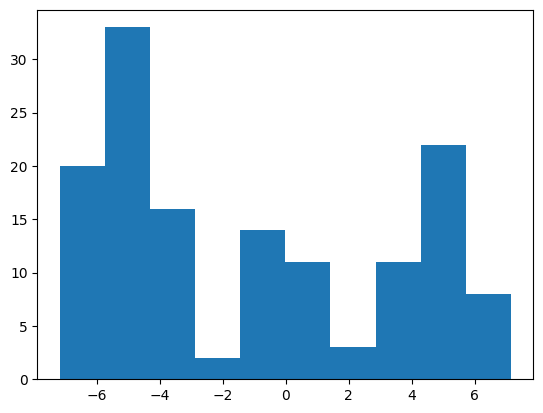

In [82]:
I = 20
T = 7
P = 3
means = np.array([-5, 0, 5]) #vector of possible mean 
y = np.zeros(I*T)
true_clus_allocs = np.zeros(I) #cluster of each areal allocation 
for i in range(1,I+1): #for each areal location 
    true_clus = np.random.choice(np.arange(3), size=1) #choose a cluster randomly between (1,2,3)
    true_clus_allocs[i-1] = true_clus #save the cluster choosen
    y[T*(i-1):T*i] = np.random.normal(loc=means[true_clus],size= T) #sample for all the time from the cluster choosen
    # this are the data related to areal i for all time until T
plt.hist(y)

X = np.ones((I*T,P+1)) # in this way the first column is made by one
for i in range(I*T):
   X[i,1:] = np.random.normal(loc=1,size= P) #the other P covariates are choosen randomly


mu_0 = np.zeros(P+1) #as in the paper
mu_w_1 = np.zeros(I) #as in the paper

W_raw = np.eye(I) #proximity matrix, ones in the diagonal, symm, just made by 1 or 0
for i in range(I):
    for j in range(i):
        W_raw[i,j] = np.random.binomial(size=1, n=1, p= 0.5) #choosen rand from a bernoulli
        W_raw[j,i] = W_raw[i,j] #it has to be symm
print(W_raw)

Sigma_0 = np.eye(P+1) #covariance matrix


data = {
    "I": I,
    "T": T,
    "P": P,
    "H": 10,
    "y": y,
    "X": X,
    "W_raw": W_raw,
    "mu_0": mu_0,
    "Sigma_0": Sigma_0,
    "mu_w_1": mu_w_1,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_tau2": 3,
    "b_tau2": 2,
    "a_sigma2": 3,
    "b_sigma2": 2,
    "alpha_rho": 5,
    "beta_rho": 1,
    "a_xi": 1,
    "b_xi": 1
}


In [83]:
true_clus_allocs

array([2., 1., 0., 0., 2., 0., 1., 0., 0., 1., 2., 0., 2., 1., 2., 0., 2.,
       0., 0., 0.])

In [84]:
fit = dp_mix.sample(data, show_console = True)

19:09:50 - cmdstanpy - INFO - Chain [1] start processing
19:09:50 - cmdstanpy - INFO - Chain [2] start processing
19:09:50 - cmdstanpy - INFO - Chain [3] start processing
19:09:50 - cmdstanpy - INFO - Chain [4] start processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 1000 (Default)
Chain [1] num_warmup = 1000 (Default)
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /tmp/tmpeyhqn0ha/w2fldjsu.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [1] seed = 51028
Chain [1] output
Chai

Chain [3] Iteration:    1 / 2000 [  0%]  (Warmup)
Chain [2] Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain [2] Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[2,7] = 1.6882e+09, but Covariance matrix[7,2] = 1.6882e+09 (in '/home/anna-ubuntu/bayesian-project/bayesian.stan', line 114, column 4 to column 49)
Chain [2] If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
Chain [2] but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
Chain [2] 
Chain [2] Iteration:    1 / 2000 [  0%]  (Warmup)
Chain [4] Iteration:    1 / 2000 [  0%]  (Warmup)
Chain [3] Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain [3] Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1

Chain [1] Iteration: 1700 / 2000 [ 85%]  (Sampling)
Chain [3] Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain [2] Iteration: 2000 / 2000 [100%]  (Sampling)


19:31:24 - cmdstanpy - INFO - Chain [2] done processing


Chain [2] 
Chain [2] Elapsed Time: 632.341 seconds (Warm-up)
Chain [2] 661.178 seconds (Sampling)
Chain [2] 1293.52 seconds (Total)
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 

19:32:33 - cmdstanpy - INFO - Chain [4] done processing


Chain [4] 
Chain [4] Elapsed Time: 706.814 seconds (Warm-up)
Chain [4] 656.15 seconds (Sampling)
Chain [4] 1362.96 seconds (Total)
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [1] Iteration: 1900 / 2000 [ 95%]  (Sampling)
Chain [3] Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain [1] Iteration: 2000 / 2000 [100%]  (Sampling)


19:33:35 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] 
Chain [1] Elapsed Time: 757.937 seconds (Warm-up)
Chain [1] 667.24 seconds (Sampling)
Chain [1] 1425.18 seconds (Total)
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 


19:34:18 - cmdstanpy - INFO - Chain [3] done processing
19:34:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = 1.06972e+15, but Covariance matrix[2,1] = 1.06972e+15 (in '/home/anna-ubuntu/bayesian-project/bayesian.stan', line 114, column 4 to column 49)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,5] = 4.92541e+13, but Covariance matrix[5,1] = 4.92541e+13 (in '/home/anna-ubuntu/bayesian-project/bayesian.stan', line 114, column 4 to column 49)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = -nan, but Covariance matrix[2,1] = -nan (in '/home/anna-ubuntu/bayesian-project/bayesian.stan', line 114, column 4 to column 49)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,11] = 2.26259e+47, but Covariance matrix[11,1] = 2.26259e+47 (in '/home/anna-ubuntu/bayesian-project/

Chain [3] 
Chain [3] Elapsed Time: 888.738 seconds (Warm-up)
Chain [3] 579.077 seconds (Sampling)
Chain [3] 1467.82 seconds (Total)
Chain [3] 
Chain [3] 


In [85]:
fit = az.from_cmdstanpy(fit)

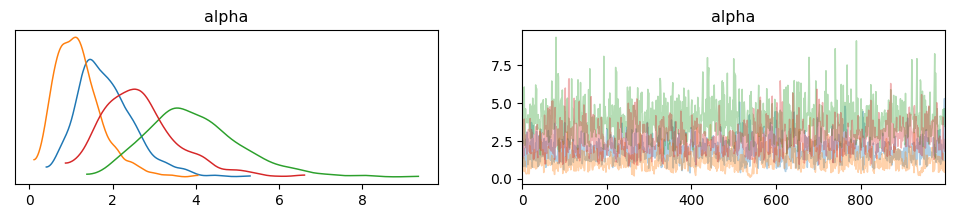

In [86]:
az.plot_trace(fit, var_names=["alpha"], compact=False)
plt.show()


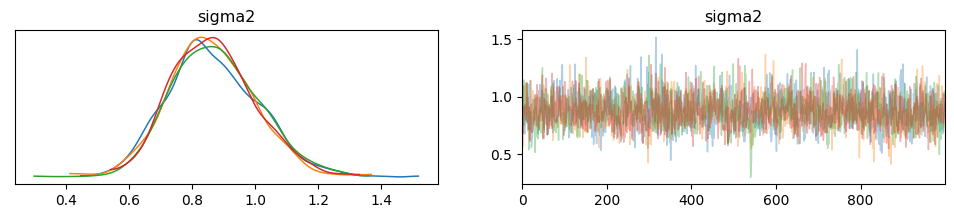

In [87]:
az.plot_trace(fit, var_names=["sigma2"], compact=False)
plt.show()

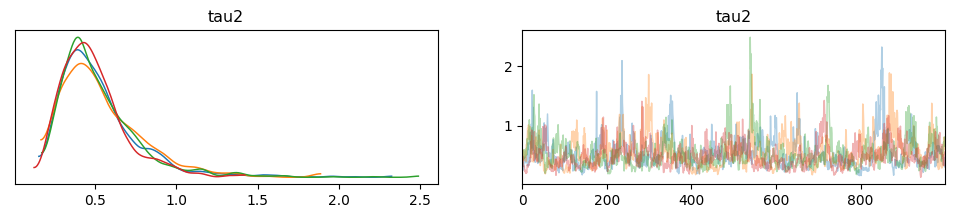

In [89]:
az.plot_trace(fit, var_names=["tau2"], compact=False)
plt.show()

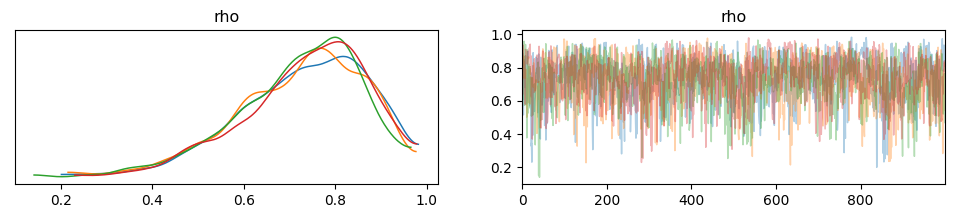

In [90]:
az.plot_trace(fit, var_names=["rho"], compact=False)
plt.show()

/home/anna-ubuntu/.local/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/anna-ubuntu/.local/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/anna-ubuntu/.local/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/anna-ubuntu/.local/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/anna-ubuntu/.local/lib/pyt

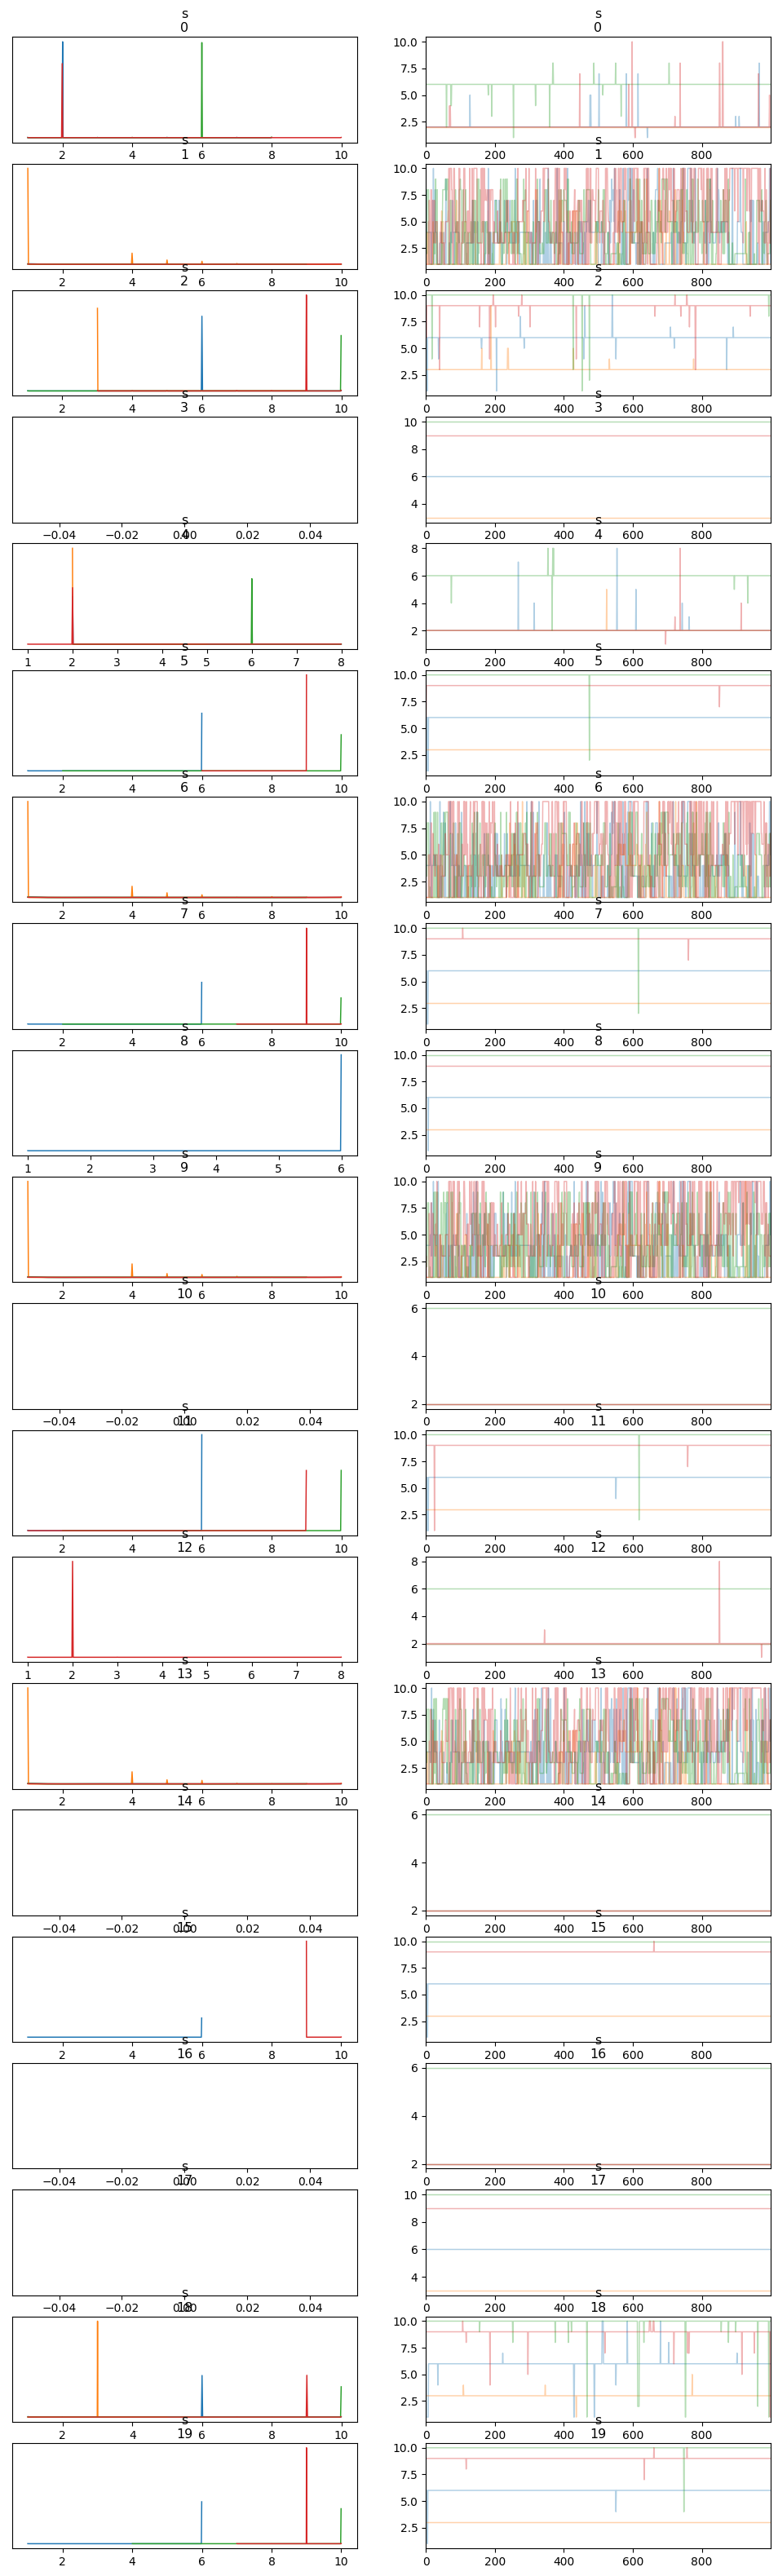

In [91]:
az.plot_trace(fit, var_names=["s"], compact=False)
plt.show()

In [92]:
clus =  np.array(fit.posterior.s.values[0, -1, :])
print('s')
print(clus)
print('true clusters')
print(true_clus_allocs)


s
[2. 1. 6. 6. 2. 6. 5. 6. 6. 5. 2. 6. 2. 5. 2. 6. 2. 6. 6. 6.]
true clusters
[2. 1. 0. 0. 2. 0. 1. 0. 0. 1. 2. 0. 2. 1. 2. 0. 2. 0. 0. 0.]


/home/anna-ubuntu/.local/lib/python3.10/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (40), generating only 20 plots
  warnings.warn(


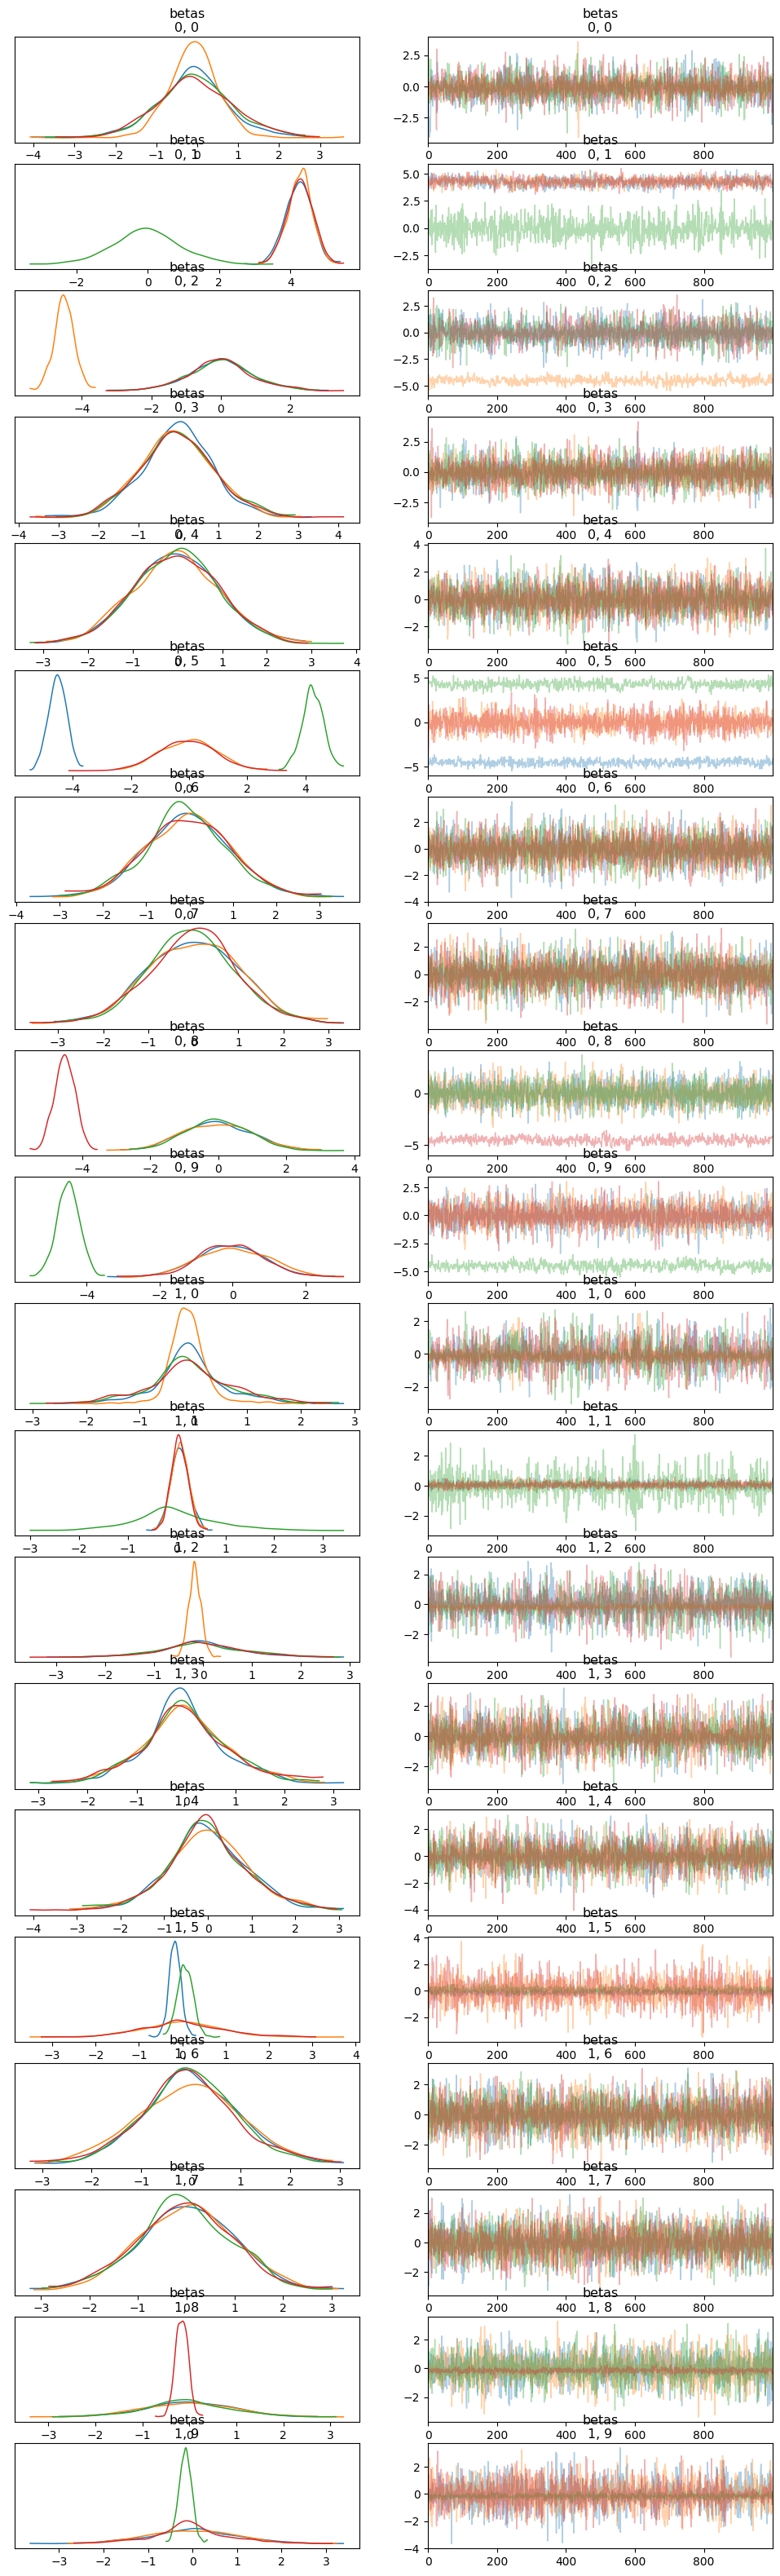

In [93]:
az.plot_trace(fit, var_names=["betas"], compact=False)
plt.show()